In [1]:
# langkah 1: Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,5)


In [2]:
# langkah 2: Load Dataset (Confirmed Indonesia)
df = pd.read_csv("dataset/time_series_covid_19_confirmed.csv")

# Deteksi kolom negara
country_col = "Country/Region" if "Country/Region" in df.columns else "Country_Region"

# Ambil data Indonesia
indo = df[df[country_col] == "Indonesia"]

# Kolom tanggal (time-series)
meta_cols = ["Province/State", "Province_State", "Lat", "Long", country_col]
date_cols = [c for c in df.columns if c not in meta_cols]

# Jumlahkan jika ada beberapa baris
I_data_full = indo[date_cols].sum().to_numpy()

# Mulai dari hari pertama dengan kasus > 0
idx0 = np.argmax(I_data_full > 0)

I_data = I_data_full[idx0:]
t_data = np.arange(len(I_data))


print("Jumlah hari:", len(I_data))
print("Kasus awal:", I_data[0])
print("Kasus akhir:", I_data[-1])


Jumlah hari: 454
Kasus awal: 2
Kasus akhir: 1809926


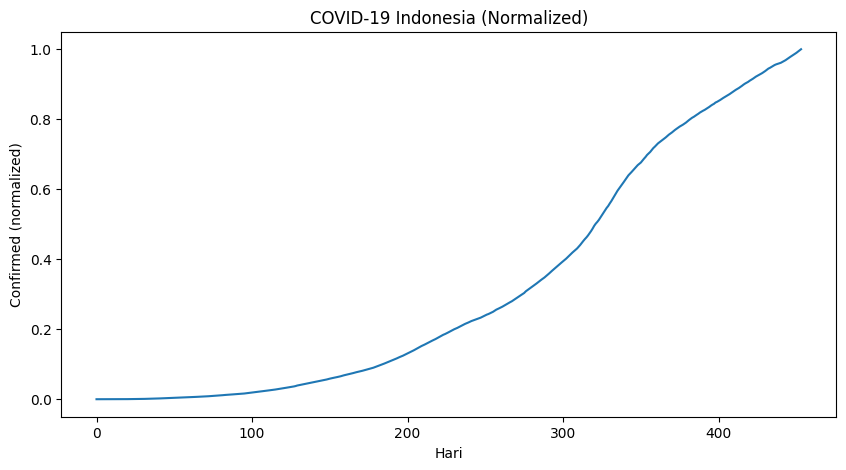

In [3]:
# langkah 3: Normalisasi Data
I_max = I_data.max()
I_norm = I_data / I_max

plt.plot(t_data, I_norm)
plt.xlabel("Hari")
plt.ylabel("Confirmed (normalized)")
plt.title("COVID-19 Indonesia (Normalized)")
plt.show()


In [4]:
# langkah 4: Model SIR (ODE)
def sir_model(t, y, beta, gamma):
    S, I, R = y
    N = S + I + R
    dS = -beta * S * I / N
    dI = beta * S * I / N - gamma * I
    dR = gamma * I
    return np.array([dS, dI, dR])


In [5]:
# langkah 5: RK4 Solver
def rk4_solver(f, t0, y0, t_end, h, params):
    t = t0
    y = np.array(y0, dtype=float)
    T, Y = [t], [y.copy()]

    while t < t_end:
        k1 = h * f(t, y, *params)
        k2 = h * f(t + h/2, y + k1/2, *params)
        k3 = h * f(t + h/2, y + k2/2, *params)
        k4 = h * f(t + h, y + k3, *params)

        y = y + (k1 + 2*k2 + 2*k3 + k4)/6
        y = np.maximum(y, 0)  # jaga agar tidak negatif
        t += h

        T.append(t)
        Y.append(y.copy())

    return np.array(T), np.array(Y)


In [6]:
# langkah 6: kondisi awal
I0 = I_norm[0]
R0 = 0
S0 = 1 - I0

y0 = [S0, I0, R0]
t0 = 0
t_end = t_data[-1]
h = 1.0  # 1 hari

y0


[np.float64(0.9999988949824468), np.float64(1.1050175532038326e-06), 0]

In [7]:
# langkah 7: RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))


In [8]:
# langkah 8: Parameter Tuning (Grid Search)
beta_range = np.linspace(0.05, 1.5, 50)
gamma_range = np.linspace(0.01, 0.5, 50)

best = None

for beta in beta_range:
    for gamma in gamma_range:
        T, Y = rk4_solver(sir_model, t0, y0, t_end, h, (beta, gamma))
        if len(T) != len(I_norm):
            continue
        I_sim = Y[:,1]
        error = rmse(I_norm, I_sim)

        if best is None or error < best["rmse"]:
            best = {
                "beta": beta,
                "gamma": gamma,
                "rmse": error,
                "T": T,
                "I_sim": I_sim
            }

best


{'beta': np.float64(0.05),
 'gamma': np.float64(0.01),
 'rmse': np.float64(0.2500471117167266),
 'T': array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
        110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
        121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132

Beta terbaik : 0.05
Gamma terbaik: 0.01
RMSE         : 0.2500471117167266


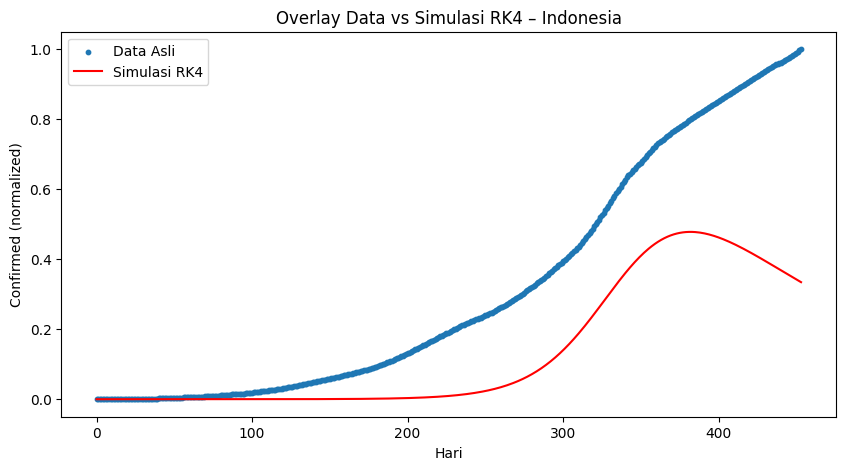

In [9]:
# langkah 9: Plot Overlay
print("Beta terbaik :", best["beta"])
print("Gamma terbaik:", best["gamma"])
print("RMSE         :", best["rmse"])

plt.scatter(t_data, I_norm, label="Data Asli", s=10)
plt.plot(best["T"], best["I_sim"], label="Simulasi RK4", color="red")
plt.xlabel("Hari")
plt.ylabel("Confirmed (normalized)")
plt.title("Overlay Data vs Simulasi RK4 – Indonesia")
plt.legend()
plt.show()


In [10]:
# langkah 10: Interpretasi Parameter
print(f"Laju penularan (β) = {best['beta']:.3f}")
print(f"Laju pemulihan (γ) = {best['gamma']:.3f}")
print(f"Perkiraan waktu pemulihan ≈ {1/best['gamma']:.2f} hari")


Laju penularan (β) = 0.050
Laju pemulihan (γ) = 0.010
Perkiraan waktu pemulihan ≈ 100.00 hari
